In [4]:
# Import the TensorFlow library for building and training neural networks
import tensorflow as tf

# Import the Keras API from TensorFlow, which provides higher-level abstractions for deep learning models
from tensorflow import keras

# Import the NumPy library for numerical operations, especially useful for handling arrays and matrices
import numpy as np

# Import the os module for interacting with the operating system (such as handling files and directories)
import os

# Import the Path class from the pathlib module to work with filesystem paths in an object-oriented manner
from pathlib import Path

# Set a random seed in NumPy for reproducibility, ensuring consistent random number generation across runs
np.random.seed(42)

# Set a random seed in TensorFlow to ensure that the random initialization of weights and other elements is consistent across runs
tf.random.set_seed(42)

# Import the matplotlib library, which is widely used for creating static, animated, and interactive visualizations in Python
import matplotlib as mpl

# Import pyplot from matplotlib, a module designed to make matplotlib plotting easier
import matplotlib.pyplot as plt

# Explanation of components:
# - TensorFlow is a deep learning framework widely used for building neural networks, including image recognition, NLP, etc.
# - Keras is an easy-to-use API in TensorFlow, allowing you to quickly build neural networks with minimal code.
# - NumPy is a powerful library for handling arrays and matrices, essential in machine learning and deep learning workflows.
# - Matplotlib is a library for creating visualizations such as plots and graphs, which is often used for understanding data distributions or model performance.
# - The random seeds (set in both NumPy and TensorFlow) ensure that your code produces the same "random" results each time it is run, which is important when debugging or reproducing results.


# Basic RNNs

## Generate the Dataset

In [5]:
# Function to generate a batch of synthetic time series data
# - batch_size: The number of time series to generate in one batch.
# - n_steps: The number of time steps (data points) in each time series.
def generate_time_series(batch_size, n_steps):

    # Generate random frequencies and offsets for two sine waves:
    # np.random.rand(4, batch_size, 1) generates four arrays of shape (batch_size, 1) with random values in the range [0, 1).
    # These random values will act as parameters for generating the sine waves.
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)

    # Create an array of evenly spaced values between 0 and 1, with n_steps values.
    # This represents the time axis for the time series.
    time = np.linspace(0, 1, n_steps)

    # First sine wave component:
    # - (time - offsets1): Time is shifted by the random offset for wave 1.
    # - (freq1 * 10 + 10): Frequency of the sine wave is calculated based on the random frequency (freq1) scaled by a factor of 10 and then shifted by 10.
    # - 0.5 * np.sin(...): The sine wave is generated and its amplitude is scaled by 0.5.
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # Wave 1

    # Second sine wave component:
    # - (time - offsets2): Time is shifted by the random offset for wave 2.
    # - (freq2 * 20 + 20): Frequency of the sine wave is calculated based on the random frequency (freq2) scaled by a factor of 20 and then shifted by 20.
    # - 0.2 * np.sin(...): The sine wave is generated and its amplitude is scaled by 0.2.
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + Wave 2

    # Add random noise to the time series:
    # - np.random.rand(batch_size, n_steps): Generates random noise in the shape of (batch_size, n_steps).
    # - (np.random.rand(...) - 0.5): Shifts the random values to be in the range [-0.5, 0.5], ensuring both positive and negative noise.
    # - 0.1 * (...): Scales the noise by 0.1 to keep it relatively small compared to the sine wave amplitudes.
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + Noise

    # Add an extra dimension to the series:
    # - series[..., np.newaxis]: Adds a new axis at the end, converting the array shape from (batch_size, n_steps) to (batch_size, n_steps, 1).
    #   This is done because many machine learning models expect a 3D input: (batch_size, time steps, features).
    # - astype(np.float32): Ensures the data type is 32-bit floating point, which is the standard data type for neural networks in TensorFlow.
    return series[..., np.newaxis].astype(np.float32)

# Explanation of key concepts:
# - Time series data is a sequence of data points, typically measured at successive times, spaced at uniform time intervals.
# - Sine waves are used here because they are simple and periodic, which makes them ideal for testing time series models.
# - Adding random noise helps to simulate real-world data, which is often noisy and unpredictable.
# - This function generates a batch of synthetic time series data, useful for training machine learning models such as RNNs or LSTMs.


In [6]:
# Set the random seed for reproducibility.
# This ensures that the random numbers generated will be the same every time the code is run.
np.random.seed(42)

# Number of time steps (data points) in each time series.
# n_steps represents the length of each input sequence, excluding the target value (which will be the next step to predict).
n_steps = 50

# Generate a dataset of 10,000 time series, each with n_steps + 1 points.
# The last point in each series will serve as the target value (y), and the first n_steps will be used as the input (X).
series = generate_time_series(10000, n_steps + 1)

# Split the dataset into training, validation, and test sets:

# Training set:
# - X_train: The first 7000 time series are used for training. We use only the first n_steps as input (shape: 7000, 50, 1).
# - y_train: The target value is the last time step (n_steps + 1) in each time series. This will be used as the value to predict (shape: 7000, 1).
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]

# Validation set:
# - X_valid: The time series from index 7000 to 8999 are used for validation. Again, the first n_steps are used as input (shape: 2000, 50, 1).
# - y_valid: The target value for validation is the last time step in each series (shape: 2000, 1).
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]

# Test set:
# - X_test: The time series from index 9000 to 9999 are reserved for testing. The input is the first n_steps (shape: 1000, 50, 1).
# - y_test: The target value for testing is the last time step in each series (shape: 1000, 1).
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

# Explanation of key concepts:
# - The input (X) for each time series consists of the first `n_steps` values, and the output (y) is the next time step (n_steps + 1).
#   This setup is commonly used in time series prediction, where the model learns to predict the next value based on the previous time steps.
# - Training, validation, and test sets are crucial for building robust machine learning models:
#   - Training set: Used to train the model.
#   - Validation set: Used to tune the model’s hyperparameters and prevent overfitting.
#   - Test set: Used to evaluate the final performance of the model on unseen data.


In [7]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

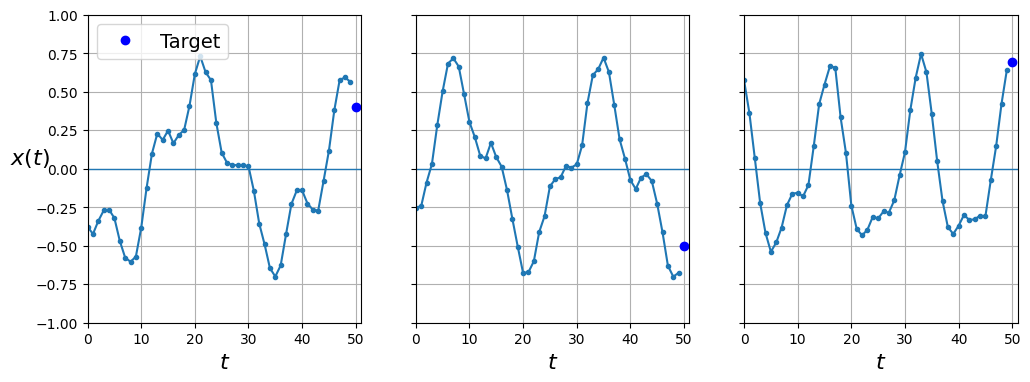

In [8]:
# Function to plot time series data, along with optional target and prediction values.
# - series: The input time series (e.g., actual values over time).
# - y: The true target value (optional), representing the next value in the time series that we're trying to predict.
# - y_pred: The predicted target value (optional), representing the model's prediction of the next value.
# - x_label, y_label: Labels for the x-axis and y-axis, respectively (default uses LaTeX-style math formatting for time and function notation).
# - legend: A boolean that determines whether to display the legend, which shows labels for the target and prediction (if provided).
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):

    # Plot the time series as a line with dots at each data point.
    plt.plot(series, ".-")

    # If the true target value `y` is provided, plot it as a blue dot ('bo') at the final time step (n_steps).
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")  # Blue dot represents the actual target value.

    # If the predicted value `y_pred` is provided, plot it as a red 'x' ('rx') at the final time step (n_steps).
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")  # Red 'x' represents the predicted value.

    # Display a grid to make the plot easier to read.
    plt.grid(True)

    # Set the label for the x-axis, if provided.
    if x_label:
        plt.xlabel(x_label, fontsize=16)  # Font size is set to 16 for readability.

    # Set the label for the y-axis, if provided.
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)  # Rotation=0 keeps the label horizontal for clarity.

    # Add a horizontal line at y=0 for reference.
    plt.hlines(0, 0, 100, linewidth=1)

    # Set the axis limits:
    # - The x-axis ranges from 0 to n_steps + 1 (to give some space for the target value).
    # - The y-axis ranges from -1 to 1 (adjust based on the scale of the data being plotted).
    plt.axis([0, n_steps + 1, -1, 1])

    # If either the true target `y` or the predicted value `y_pred` is provided, display the legend:
    # - legend=True ensures the labels ("Target" and/or "Prediction") appear on the plot.
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")  # Font size is set to 14 and the legend is placed in the top left.

# Plotting multiple time series in a grid layout for easy comparison.

# Create a figure with three subplots (1 row, 3 columns) that share the y-axis (sharey=True) for easy comparison.
# - figsize=(12, 4) specifies the width and height of the entire figure.
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

# Loop through the columns to plot three different time series from the validation set (X_valid).
for col in range(3):

    # Select the current subplot (axes[col]) for plotting.
    plt.sca(axes[col])  # sca: Set the current axis to the subplot corresponding to the current column.

    # Plot the time series for the `col`th example in the validation set:
    # - X_valid[col, :, 0]: The input time series (50 time steps) for the `col`th example.
    # - y_valid[col, 0]: The true target value for the `col`th example.
    # - y_label: Add the y-axis label ("$x(t)$") only for the first plot (col==0).
    # - legend: Display the legend only for the first plot (col == 0).
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col == 0 else None),  # Add y-axis label only for the first subplot.
                legend=(col == 0))  # Show the legend only in the first subplot.

# Display the figure with the three subplots, showing time series, target values, and (optionally) predictions.
plt.show()

# Explanation of key concepts:
# - This visualization function is essential for understanding the performance of time series models by comparing the true target values to the predicted values.
# - By plotting multiple time series side by side, it becomes easier to compare how well the model predicts the next step.
# - The legend and axis labels provide clarity for interpreting the plots, making it easier to identify the true values and predictions.


## Using a Simple RNN

In [9]:
# Set random seeds for reproducibility.
# This ensures that both NumPy and TensorFlow generate the same "random" numbers every time the code is run.
np.random.seed(42)
tf.random.set_seed(42)

# Define the RNN model using Keras' Sequential API:
# - keras.models.Sequential: This creates a linear stack of layers, where each layer has one input tensor and one output tensor.
model = keras.models.Sequential([

    # Add a Simple Recurrent Neural Network (SimpleRNN) layer:
    # - SimpleRNN(1): This is an RNN layer with a single output unit (1 neuron). The "1" means the output will be a scalar value for each sequence.
    # - input_shape=[None, 1]: Specifies that the input will have an unspecified number of time steps (None), with 1 feature per time step (univariate time series).
    #   This allows the RNN to handle variable-length input sequences during inference.
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# Explanation of key components:
# - SimpleRNN is a basic type of Recurrent Neural Network that maintains a hidden state to remember information across time steps.
# - This is a minimal RNN architecture, with just one neuron, designed for simple time series forecasting tasks.
# - The input_shape=[None, 1] allows the model to process univariate time series with a flexible number of time steps.
#   - `None`: The number of time steps in the input sequence can vary (useful for real-world data with variable length).
#   - `1`: There is only one feature per time step (e.g., a single measured value at each time step).

# Set up the optimizer:
# - keras.optimizers.Adam: Adam is a popular optimizer that adapts the learning rate during training for better convergence.
# - learning_rate=0.005: Specifies the initial learning rate for the optimizer. This controls the step size at each iteration when the weights are updated.
#   - A small learning rate (0.005) ensures that the model learns gradually, preventing overshooting of the optimal parameters.
optimizer = keras.optimizers.Adam(learning_rate=0.005)

# Compile the model:
# - loss="mse": Mean Squared Error (MSE) is used as the loss function, which measures the average squared difference between predicted and true values.
#   - MSE is commonly used for regression tasks like time series forecasting.
# - optimizer=optimizer: Use the Adam optimizer (with the specified learning rate) to adjust the model weights during training.
model.compile(loss="mse", optimizer=optimizer)

# Train the model using the training data:
# - X_train: The input sequences (first 50 time steps of each series).
# - y_train: The target values (next time step after the 50 time steps in the input).
# - epochs=20: Train the model for 20 epochs (i.e., go through the entire training dataset 20 times).
# - validation_data=(X_valid, y_valid): During training, the model will also evaluate its performance on the validation set after each epoch.
#   - This helps monitor the model's performance and detect overfitting or underfitting.
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

# Explanation of key components in model training:
# - The model.fit() function trains the RNN model by adjusting the weights based on the training data (X_train, y_train).
# - Training for 20 epochs means that the model will pass through the training dataset 20 times, updating weights at each step.
# - The validation data (X_valid, y_valid) is used to monitor how well the model generalizes to unseen data during training.
#   - If the validation loss improves along with the training loss, it indicates that the model is learning effectively without overfitting.
# - The loss function, "mse" (Mean Squared Error), is minimized during training to make the predictions closer to the true target values.

# This model, though simple, demonstrates the core concepts of using an RNN for time series prediction.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2267 - val_loss: 0.0317
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0293 - val_loss: 0.0236
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223 - val_loss: 0.0188
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0158
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - val_loss: 0.0139
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.0126
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0118
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [10]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110


0.010924565605819225

In [11]:
# Function to plot the learning curves, which show how the loss changes over the course of training.
# - loss: The list of training losses recorded after each epoch.
# - val_loss: The list of validation losses recorded after each epoch.

def plot_learning_curves(loss, val_loss):

    # Plot the training loss over the epochs:
    # - np.arange(len(loss)) creates an array of values from 0 to len(loss) - 1 (one value for each epoch).
    # - np.arange(len(loss)) + 0.5 shifts the x-axis labels for the training loss slightly to the right for better visibility.
    # - "b.-": The line style; "b" stands for blue, ".-" means a line with dots at each data point.
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")

    # Plot the validation loss over the epochs:
    # - np.arange(len(val_loss)) creates an array of values from 0 to len(val_loss) - 1 (one value for each epoch).
    # - np.arange(len(val_loss)) + 1 shifts the x-axis labels for the validation loss slightly more to the right.
    # - "r.-": The line style; "r" stands for red, ".-" means a line with dots at each data point.
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")

    # Set the x-axis to display only integer values (since epochs are discrete).
    # mpl.ticker.MaxNLocator(integer=True) ensures the tick marks on the x-axis are integer values (1, 2, 3, etc.).
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

    # Set the axis limits:
    # - The x-axis ranges from 1 to 20 (since we trained for 20 epochs).
    # - The y-axis ranges from 0 to 0.05 (this range depends on the scale of the loss values in your model).
    plt.axis([1, 20, 0, 0.05])

    # Add a legend to differentiate between the training and validation loss curves:
    # - label="Training loss" and label="Validation loss" were used in the plt.plot() calls earlier to name the lines.
    # - fontsize=14 ensures that the legend text is large and readable.
    plt.legend(fontsize=14)

    # Add a label to the x-axis to indicate the number of epochs (training iterations).
    plt.xlabel("Epochs")

    # Add a label to the y-axis to show that the values being plotted are loss values.
    plt.ylabel("Loss")

    # Display a grid on the plot to make it easier to read the values.
    plt.grid(True)

# Explanation of key concepts:
# - The function plots the loss values (training and validation) over the epochs, helping visualize how the model's performance improves or worsens.
# - Loss functions measure how far the model's predictions are from the true values, and the goal is to minimize the loss.
# - The training loss indicates how well the model fits the training data, while the validation loss indicates how well it generalizes to unseen data.
# - A decreasing training loss and a stable or decreasing validation loss over time suggest good model performance.


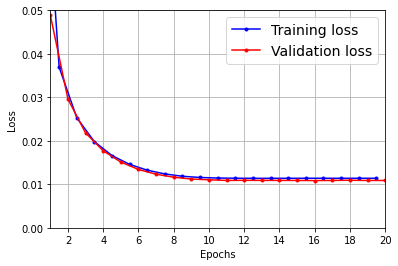

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

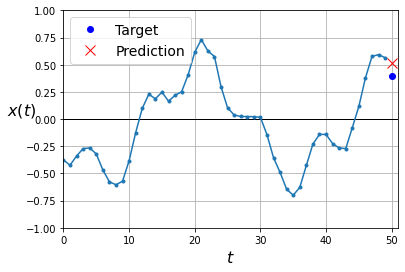

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [12]:
# Set random seeds for reproducibility, ensuring that the results are the same each time the code is run.
np.random.seed(42)
tf.random.set_seed(42)

# Define the Recurrent Neural Network (RNN) model using Keras' Sequential API:
# - keras.models.Sequential: This creates a linear stack of layers where the output of one layer is the input to the next.
model = keras.models.Sequential([

    # First SimpleRNN layer:
    # - SimpleRNN(20): This layer has 20 units (neurons), meaning it will output a sequence of 20-dimensional vectors.
    # - return_sequences=True: This ensures that the RNN returns the full sequence of outputs (hidden states) for each time step.
    #   This is necessary when stacking multiple RNN layers because the next RNN layer will need the full sequence as input.
    # - input_shape=[None, 1]: The input shape indicates that the input sequence can have any number of time steps (None), and each time step contains 1 feature.
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),

    # Second SimpleRNN layer:
    # - SimpleRNN(20): Another RNN layer with 20 units (neurons).
    # - return_sequences=True: Once again, we return the full sequence of outputs because we want to pass these outputs to the next layer.
    keras.layers.SimpleRNN(20, return_sequences=True),

    # Final SimpleRNN layer:
    # - SimpleRNN(1): This is the output layer. It has only 1 unit (neuron), which predicts the next value in the time series (univariate prediction).
    # - Since return_sequences=False by default, this layer will output a single value (the prediction for the next time step) rather than a sequence.
    keras.layers.SimpleRNN(1) # output layer
])

# Explanation of key components in the model architecture:
# - The model consists of three SimpleRNN layers.
# - The first two layers are designed to return sequences (return_sequences=True) so that the next layer in the stack can process the entire sequence.
# - The final SimpleRNN layer has only 1 output neuron (return_sequences=False by default), which predicts the next time step's value in the series.
# - This setup enables the model to learn from sequential patterns in the data across multiple time steps, making it suitable for time series forecasting.

# Compile the model:
# - loss="mse": We use Mean Squared Error (MSE) as the loss function. This measures the average squared difference between predicted and true values.
# - optimizer="adam": The Adam optimizer is used for training. It's an adaptive learning rate optimizer that adjusts the learning rate during training.
model.compile(loss="mse", optimizer="adam")

# Train the model:
# - X_train: The training input data (first 50 time steps for each series).
# - y_train: The corresponding target values (next time step after the 50 input steps).
# - epochs=20: The model will be trained for 20 epochs, meaning it will pass through the entire training dataset 20 times.
# - validation_data=(X_valid, y_valid): This provides validation data to monitor the model's performance on unseen data after each epoch.
#   - This helps in detecting issues like overfitting (where the model performs well on training data but poorly on validation data).
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

# Explanation of key components in model training:
# - model.fit(): This function trains the model. It updates the weights of the network during each epoch to minimize the loss.
# - The model is trained using X_train (the input sequences) and y_train (the target values, which are the next time steps).
# - The validation data (X_valid, y_valid) is used to monitor how well the model generalizes to unseen data.
# - If the validation loss decreases along with the training loss, it indicates that the model is learning effectively and not overfitting.


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0658 - val_loss: 0.0050
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0029


0.0029105606954544783

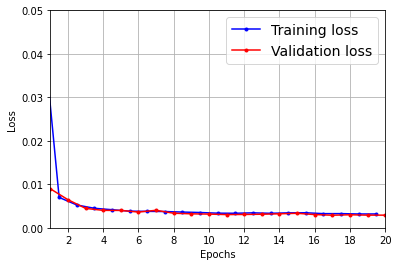

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

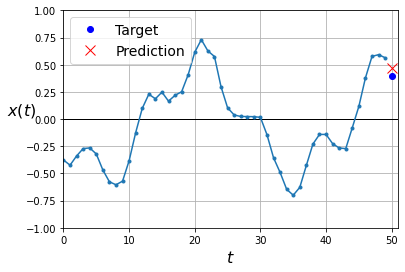

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()